# Modelling for classification task

This notebook chapter focuses on training models for solving classification problems.
The following steps will be:

1. Train 4 different types of machine learning models, including
    - Logistic Regression
    - kNN
    - Decision Tree and Random Forest
    - XGBoost Classifier
    - Additionally, Balanced Bagging Classifier

2. Perform the hyperparameter tuning procedure in two ways
    - Sklearn: Randomised Search
    - Hyperopt: Bayesian Optimisation.

3. Compare the quality of the models.
    - Calculate F1 score and average precision score
    - Find the better threshold for each individual classifier to determine what probability is critical for assigning a class 1
  


In [1]:
%load_ext autoreload
%autoreload 2

# Data Loading

Let's put the data preparation for all the models in a separate file `process_bank_debit.py` Which includes:
-  splitting the data into test and train
- encoding of categorical and numerical columns.
- Also, the function of normalization (through standardisation) is implemented if necessary

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, average_precision_score

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.process_bank_debit import preprocess_data, preprocess_new_data

pd.set_option('display.max.columns',100)
pd.set_option('float_format', '{:.2f}'.format)

In [2]:
df = pd.read_csv('../data//bank-additional-full-clean.csv')

data_processed = preprocess_data(df, target='target')
data_processed_WOstand = preprocess_data(df, target='target', scaler_numeric= False)

data_processed['train_X'].shape, data_processed['train_y'].shape, data_processed['val_X'].shape, data_processed['val_y'].shape

((31519, 53), (31519,), (7880, 53), (7880,))

In [4]:
display(data_processed['train_X'].head(), data_processed_WOstand['train_X'].head())

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pdays_binary,employment_to_price,economic_index,month_sin,month_cos,day_sin,day_cos,has_holiday,month_positive,marital_divorced,marital_married,marital_single,marital_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,education_grouped_Basic Education,education_grouped_Courses,education_grouped_Junior Education,education_grouped_Secondary Education,education_grouped_University Degree,education_grouped_Unknown,job_category_Blue-collar,job_category_Other,job_category_White-collar,age_group_Middle-aged,age_group_Senior,age_group_Young,age_group_nan,financial_risk_Low Risk,season_Autumn,season_Spring,season_Summer,season_Winter
26641,-0.01,-0.58,0.20,1.64,-1.18,-0.86,-1.42,-1.22,-0.92,-0.20,-0.63,-1.68,1.56,0.14,0.00,1.43,0.50,-0.97,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
35715,-0.11,-0.58,0.20,-0.35,-1.88,-2.35,1.96,-1.57,-1.24,-0.20,-0.23,0.54,-1.38,0.14,-1.33,0.44,0.50,-0.97,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
27543,0.56,-0.58,0.20,1.64,-1.18,-0.86,-1.42,-1.26,-0.92,-0.20,-0.63,-1.69,1.56,0.14,0.00,1.43,0.50,-0.97,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
31126,-0.11,-0.58,0.20,1.64,-1.18,-1.17,-1.22,-1.32,-0.92,-0.20,-0.47,-1.57,0.94,-0.51,1.34,0.44,0.50,1.04,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
13834,0.94,0.14,0.20,-0.35,0.85,0.58,-0.47,0.78,0.85,-0.20,0.70,0.08,-0.76,-0.51,1.34,0.44,-2.01,-0.97,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pdays_binary,employment_to_price,economic_index,month_sin,month_cos,day_sin,day_cos,has_holiday,month_positive,marital_divorced,marital_married,marital_single,marital_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,education_grouped_Basic Education,education_grouped_Courses,education_grouped_Junior Education,education_grouped_Secondary Education,education_grouped_University Degree,education_grouped_Unknown,job_category_Blue-collar,job_category_Other,job_category_White-collar,age_group_Middle-aged,age_group_Senior,age_group_Young,age_group_nan,financial_risk_Low Risk,season_Autumn,season_Spring,season_Summer,season_Winter
26641,40,1,999,1,-1.80,93.08,-47.10,1.48,5099.10,0,54.78,-47.42,0.87,-0.50,-0.00,1.00,1,0,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
35715,39,1,999,0,-2.90,92.20,-31.40,0.87,5076.20,0,55.06,-33.43,-0.87,-0.50,-0.95,0.31,1,0,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
27543,46,1,999,1,-1.80,93.08,-47.10,1.41,5099.10,0,54.78,-47.49,0.87,-0.50,-0.00,1.00,1,0,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
31126,39,1,999,1,-1.80,92.89,-46.20,1.30,5099.10,0,54.89,-46.70,0.50,-0.87,0.95,0.31,1,1,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
13834,50,3,999,0,1.40,93.92,-42.70,4.96,5228.10,0,55.67,-36.34,-0.50,-0.87,0.95,0.31,0,0,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00


Because different models require different input data, we created two datasets:
- standardised = `data_processed` (which we will use for logistic regressions and KNN),
- **without** standardisation = `data_processed_WOstand`(for trees and boosting algorithms)

The next step is to create a function for evaluating models. The model can be evaluated as follows:
- On the training dataset, we find the best classifier threshold between 0, 1 in increments of 0.05. Using F1 as the basis for the decision metric
- Next step is to memorise and transmit this threshold to evaluate the performance of the test data
- Our developed functions include some of our main metrics (f1, average_precision_score) and some additional ones (recall,precision) in case of need for more information
- Also, if necessary, the confusion matrix visualization is implemented to better understand the classifier's work

In [ ]:
# determine the best threshold for the model
def get_best_threshold(model, val_X, val_y):
  y_probs = model.predict_proba(val_X)[:, 1]
  f1 = []
  
  thresholds = np.arange(0.0, 1.0, 0.05)
  for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    f1.append(f1_score(val_y, y_pred_thresh))

  best_threshold = thresholds[np.argmax(f1)]
  return round(best_threshold, 2)



def evaluate_model(model, X, y, threshpld = 0.5 ,train = True):
    """
    Evaluate the model on the given dataset (X, y) and return metrics.
    """
    y_prob = model.predict_proba(X)[:, 1] 

    if train: 
        threshpld = get_best_threshold(model, X, y)
    
    y_pred = (y_prob >= threshpld).astype(int)
    
    metrics = {
        'threshold': threshpld,
        'f1': round(f1_score(y, y_pred), 4),
        'recall': round(recall_score(y, y_pred), 4),
        'precision': round(precision_score(y, y_pred), 4),
        'average_precision': round(average_precision_score(y, y_prob), 4) if y_prob is not None else None
    }

    cm = confusion_matrix(y, y_pred, normalize='true')
    return metrics, cm, threshpld

# Evaluate the model on the training set and validation set
def evaluation(model, data_processed, shw_cm = True):

    train_metrics, cm_train, threshpld = evaluate_model(model, data_processed['train_X'], data_processed['train_y'])
    val_metrics, cm_val, _ = evaluate_model(model, data_processed['val_X'], data_processed['val_y'], threshpld, train = False)

    output = {
        'train': train_metrics,
        'val': val_metrics
    }

    if shw_cm:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(cm_train, annot=True,  cmap='Blues')
        plt.title('Train')
        plt.subplot(1, 2, 2)
        sns.heatmap(cm_val, annot=True, cmap='Blues')
        plt.title('Validation')
  
    return output

# LogisticRegression

{'train': {'threshold': 0.65,
  'f1': 0.4902,
  'recall': 0.5653,
  'precision': 0.4327,
  'average_precision': 0.4424},
 'val': {'threshold': 0.65,
  'f1': 0.4969,
  'recall': 0.5696,
  'precision': 0.4407,
  'average_precision': 0.4696}}

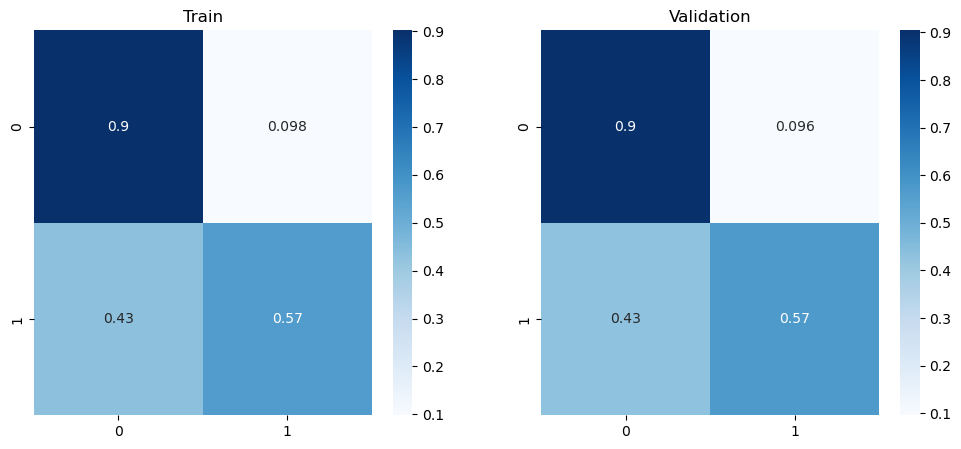

In [ ]:
regression = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
regression.fit(data_processed['train_X'], data_processed['train_y'])
eval_regression = evaluation(regression, data_processed)
eval_regression


The model was trained specifically to take into account the imbalance of classes.
The logistics regressor showed good results in training and in testing. But at this stage, it is difficult to say whether these are good performances or not, we need to compare them with other models. It would also be useful to use polynomial features to improve the model

# KNeighborsClassifier + GridSearchCV

Best params: {'n_neighbors': 19}


{'train': {'threshold': 0.25,
  'f1': 0.5119,
  'recall': 0.584,
  'precision': 0.4556,
  'average_precision': 0.4885},
 'val': {'threshold': 0.25,
  'f1': 0.4859,
  'recall': 0.5511,
  'precision': 0.4344,
  'average_precision': 0.4313}}

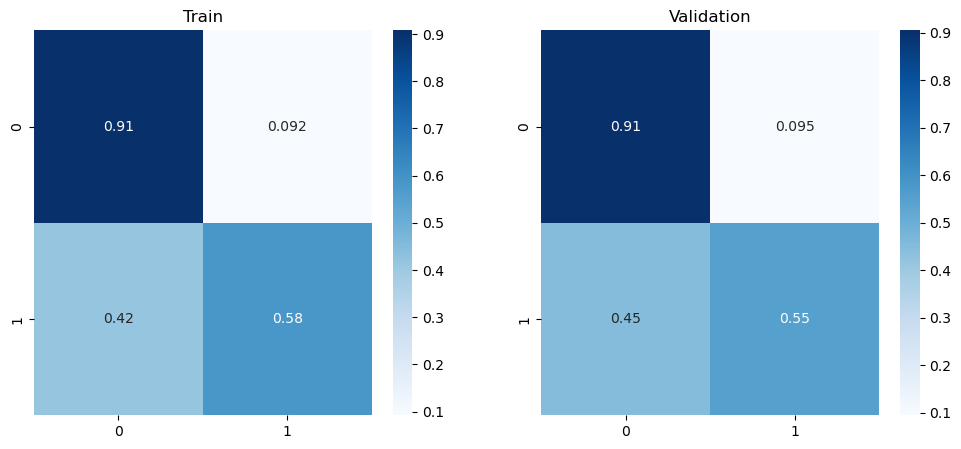

In [ ]:
param_grid = {'n_neighbors': np.arange(15, 30)}
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring="f1")
knn_grid.fit(data_processed['train_X'], data_processed['train_y'])

print (f"Best params: {knn_grid.best_params_}")
knn_best = knn_grid.best_estimator_

eval_knn = evaluation(knn_best, data_processed)
eval_knn

The KNN also works good without overfitting. the best # of the neighbors is 19

# DecisionTreeClassifier + RandomizedSearchCV

In [ ]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2'],
}

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params: {'splitter': 'random', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 19, 'max_features': None, 'max_depth': 6, 'criterion': 'entropy'}


{'train': {'threshold': 0.45,
  'f1': 0.4953,
  'recall': 0.5875,
  'precision': 0.4281,
  'average_precision': 0.4153},
 'val': {'threshold': 0.45,
  'f1': 0.5037,
  'recall': 0.5946,
  'precision': 0.4369,
  'average_precision': 0.4322}}

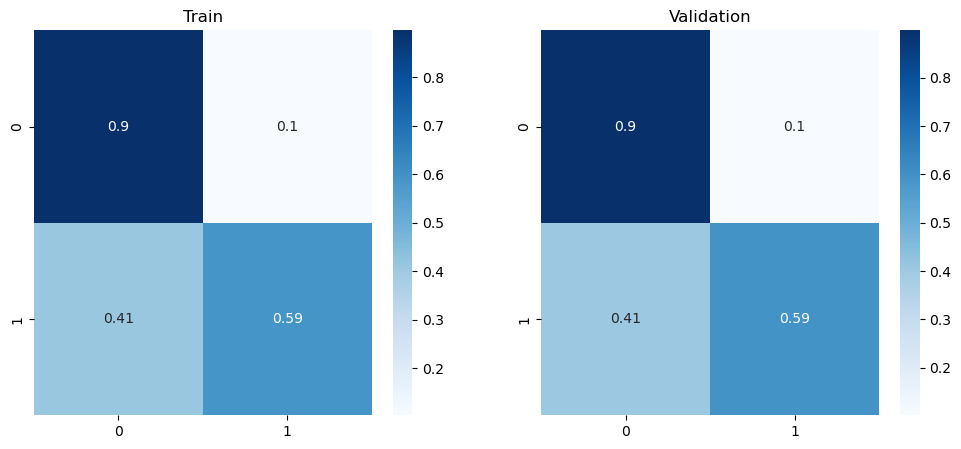

In [9]:
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_random = RandomizedSearchCV(dt, param_distributions=params_dt, n_iter=40, cv=3, scoring='roc_auc', verbose=1)
dt_random.fit(data_processed_WOstand['train_X'], data_processed_WOstand['train_y'])

print (f"Best params: {dt_random.best_params_}")
dt_random_search_best = dt_random.best_estimator_

eval_dt = evaluation(dt_random_search_best, data_processed_WOstand)
eval_dt

By applying decision trees, we managed to slightly increase the F1, especially after tuning the hyperparameters

# XGBClassifier

{'train': {'threshold': 0.6,
  'f1': 0.7124,
  'recall': 0.7175,
  'precision': 0.7073,
  'average_precision': 0.7527},
 'val': {'threshold': 0.6,
  'f1': 0.44,
  'recall': 0.4326,
  'precision': 0.4477,
  'average_precision': 0.4348}}

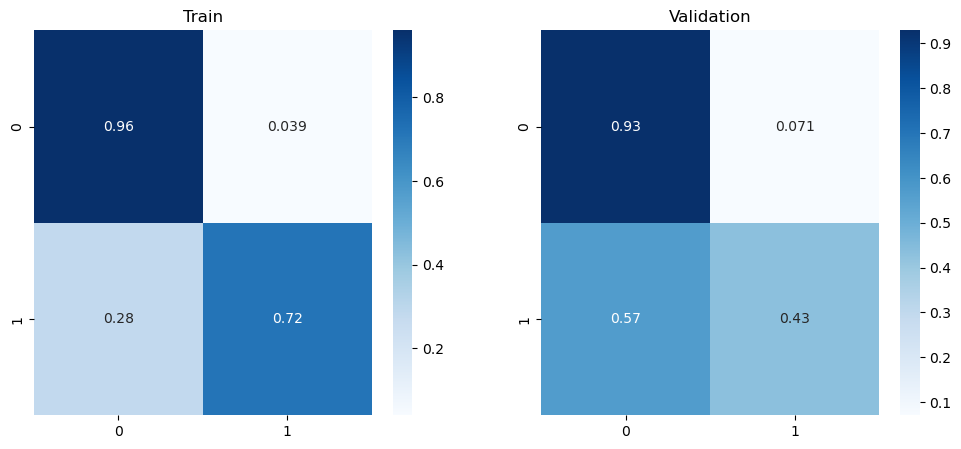

In [ ]:


count_0 = sum(data_processed_WOstand['train_y'] == 0)
count_1 = sum(data_processed_WOstand['train_y'] == 1)
scale_pos_weight = count_0 / count_1

xgb_model = xgb.XGBClassifier(random_state=42, 
                                n_estimators=70, 
                                max_depth=15, 
                                learning_rate=0.01, 
                                scale_pos_weight=scale_pos_weight)
xgb_model.fit(data_processed_WOstand['train_X'], data_processed_WOstand['train_y'])
eval_xgb = evaluation(xgb_model, data_processed_WOstand)
eval_xgb


## XGBClassifier + hyperopt

In [ ]:
def convert_int_params(params):
    int_params = ['n_estimators', 'max_depth', 'min_child_weight']
    for param in int_params:
        params[param] = int(params[param])
    return params

def create_model (params):
    """
    Create a XGBClassifier based on the hyperparameters (for optimization or best one). 
    Return the model.
    """
    params = convert_int_params(params)
      
    clf = xgb.XGBClassifier(
    n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        min_child_weight=params['min_child_weight'], 
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'], 
        gamma=params['gamma'],  
        reg_alpha=params['reg_alpha'],  
        reg_lambda=params['reg_lambda'], 
        enable_categorical=True,
        eta = params['eta'],
        missing=np.nan,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric='pre' 
    )
    return clf

100%|██████████| 30/30 [00:23<00:00,  1.27trial/s, best loss: -0.5176]
Best param:  {'colsample_bytree': 0.8572203947492492, 'eta': 0.018516291364906776, 'gamma': 0.44320394793154855, 'learning_rate': 0.10483249685895807, 'max_depth': 17, 'min_child_weight': 9, 'n_estimators': 11, 'reg_alpha': 0.7028558593683768, 'reg_lambda': 0.5524103622626125, 'subsample': 0.7491675923212758}


{'train': {'threshold': 0.6,
  'f1': 0.5799,
  'recall': 0.6294,
  'precision': 0.5376,
  'average_precision': 0.6047},
 'val': {'threshold': 0.6,
  'f1': 0.5176,
  'recall': 0.5609,
  'precision': 0.4804,
  'average_precision': 0.4911}}

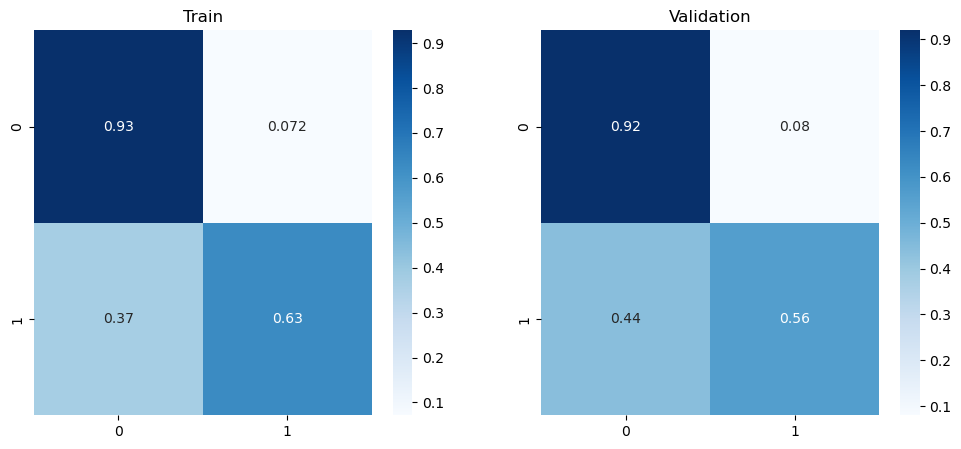

In [12]:
def objective(params):

    clf = create_model(params)

    clf.fit(
        data_processed_WOstand['train_X'],
        data_processed_WOstand['train_y'],
        eval_set=[(data_processed_WOstand['val_X'], data_processed_WOstand['val_y'])],
        verbose=False)
    eval_clf = evaluation(clf, data_processed_WOstand, shw_cm = False)
   
    return {'loss': -eval_clf.get('val').get('f1'), 'status': STATUS_OK}


space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
    'max_depth': hp.quniform('max_depth', 10, 30, 1),
    'min_child_weight': hp.quniform('min_child_weight', 5, 20, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'eta': hp.uniform('eta', 0.01, 0.9)
}


trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals = 30, trials=trials)

best_hyperopt_xgb = create_model(best)

best_hyperopt_xgb.fit(data_processed_WOstand['train_X'], data_processed_WOstand['train_y'])
eval_hpr_best = evaluation(best_hyperopt_xgb, data_processed_WOstand)

print("Best param: ", best)
eval_hpr_best

## XGBClassifier + Randomized Search

In [13]:
params_xgb = {
    'n_estimators': [50, 100, 150, 200, 300],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 10, 100]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_distributions=params_xgb,
    scoring="f1",
    n_iter=40,
    cv=3,
    random_state=42
)

random_search_xgb.fit(data_processed_WOstand['train_X'], data_processed_WOstand['train_y'])

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=40,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [50, 100, 150, 200,
                                                         300],
                                        'reg_alpha': [0, 0.1, 1, 10],
                                        'reg_lambda': [1, 10, 100],
                                        'subsample': [0.5, 0.6, 0.7]},
                   random_state=42, scoring='f1')

Best params: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}


{'train': {'threshold': 0.3,
  'f1': 0.5677,
  'recall': 0.5514,
  'precision': 0.5851,
  'average_precision': 0.612},
 'val': {'threshold': 0.3,
  'f1': 0.5008,
  'recall': 0.4848,
  'precision': 0.518,
  'average_precision': 0.4939}}

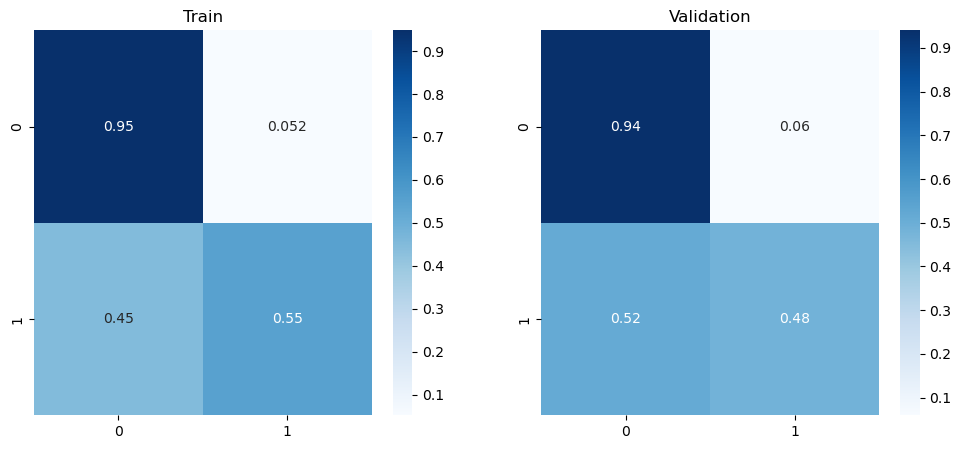

In [14]:
print (f"Best params: {random_search_xgb.best_params_}")
best_random_search_xgb = random_search_xgb.best_estimator_

eval_randon_xgb = evaluation(best_random_search_xgb, data_processed_WOstand)
eval_randon_xgb

We used three approaches for XGBClassifier algorithms. First, we tried manual tuning of the parameters, then we tried `hyperopt` and `Randomized Search`. This way we can see that the `hyperopt` method worked perfect and gave us the best results. 
We also see that the algorithm is a bit prone to overfitting (the difference between F1 test and training ranges from 0.07 to 0.4). It seems that the algorithm can still be improved.

# RandomForestClassifier

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_depth': 20, 'class_weight': 'balanced_subsample', 'bootstrap': True}


{'train': {'threshold': 0.4,
  'f1': 0.6011,
  'recall': 0.8706,
  'precision': 0.459,
  'average_precision': 0.6791},
 'val': {'threshold': 0.4,
  'f1': 0.4636,
  'recall': 0.6467,
  'precision': 0.3613,
  'average_precision': 0.4933}}

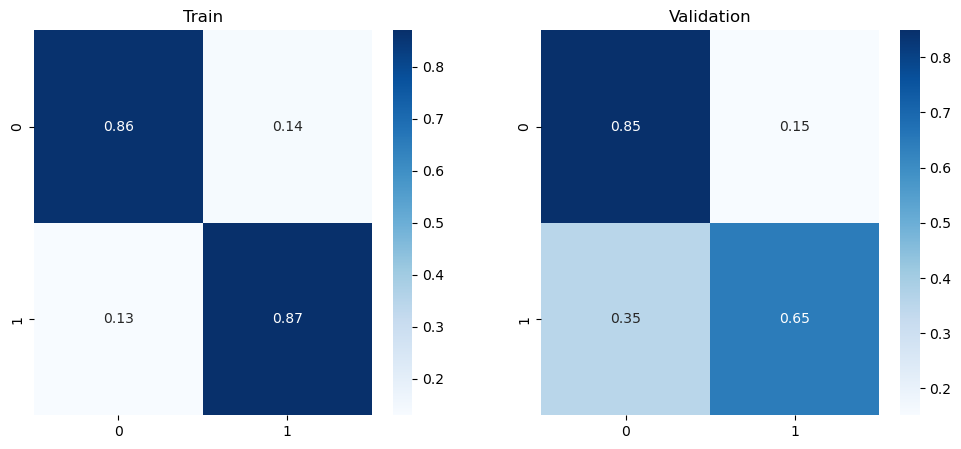

In [ ]:
params_rf = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [5, 7, 10, 20, ],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(rf, param_distributions=params_rf, n_iter=30, cv=3, scoring='f1', verbose=1)
rf_random.fit(data_processed_WOstand['train_X'], data_processed_WOstand['train_y'])
              
print (f"Best params: {rf_random.best_params_}")
rf_random_search_best = rf_random.best_estimator_

eval_rf = evaluation(rf_random_search_best, data_processed_WOstand)
eval_rf

Because in the previous iterations Decision Trees showed good results, we also tried to use Random Forest as a more reliable tree algorithm. But unfortunately the algorithm is too overfit and shows much better performance in training and but not in testing.

# BalancedBaggingClassifier

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'n_estimators': 90, 'max_samples': 0.5, 'max_features': 0.5, 'bootstrap_features': True, 'bootstrap': True}


{'train': {'threshold': 0.75,
  'f1': 0.6187,
  'recall': 0.5633,
  'precision': 0.6861,
  'average_precision': 0.7177},
 'val': {'threshold': 0.75,
  'f1': 0.47,
  'recall': 0.4217,
  'precision': 0.5308,
  'average_precision': 0.4818}}

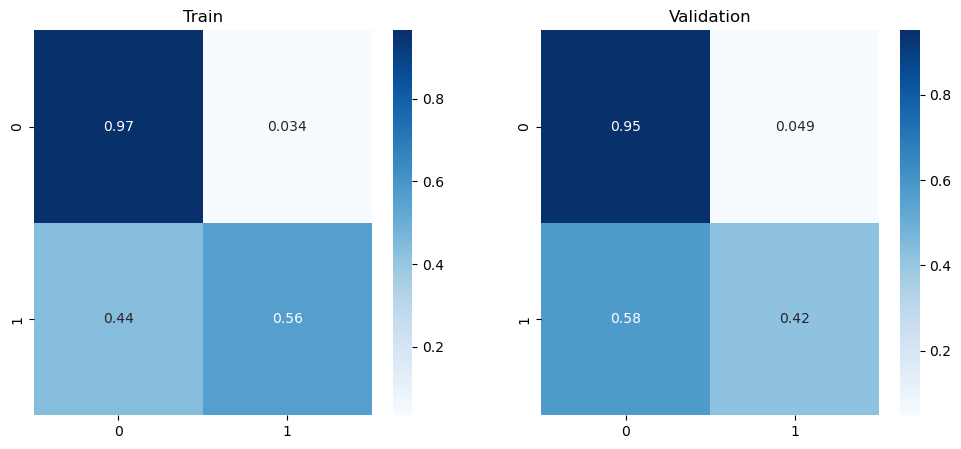

In [ ]:

params_bagging = {  
    'n_estimators': np.arange(10, 100, 10),
    'max_samples': np.arange(0.5, 1.0, 0.1),
    'max_features': np.arange(0.5, 1.0, 0.1),
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'), random_state=42, sampling_strategy='not minority')

bbc_random = RandomizedSearchCV(bbc, param_distributions=params_bagging, n_iter=30, cv=3, scoring='f1', verbose=1)

bbc_random.fit(data_processed['train_X'], data_processed['train_y'])
print (f"Best params: {bbc_random.best_params_}")
bbc_random_search_best = bbc_random.best_estimator_



eval_bbc = evaluation(bbc_random_search_best, data_processed)
eval_bbc

We also tried to apply algorithms such as Balanced Bagging Classifier that were specifically developed for unbalanced data, but our performance did not improve.

# Results

Finally, we need to collect all the results of the classifiers into one table. And we will save it in a separate file. We will also save the best models

In [18]:
full_eval = pd.DataFrame({'Logistic Regression': eval_regression['val'], 'KNN': eval_knn['val'], 'Decision Tree': eval_dt['val'], 'XGBoost': eval_xgb['val'], 'XGBoost Hyperopt': eval_hpr_best['val'], 'XGBoost Random Search': eval_randon_xgb['val'], 'Random Forest': eval_rf['val'], 'Balanced Bagging': eval_bbc['val']})
full_eval = full_eval.T*100

In [19]:
full_train = pd.DataFrame({'Logistic Regression': eval_regression['train'], 'KNN': eval_knn['train'], 'Decision Tree': eval_dt['train'], 'XGBoost': eval_xgb['train'], 'XGBoost Hyperopt': eval_hpr_best['train'], 'XGBoost Random Search': eval_randon_xgb['train'], 'Random Forest': eval_rf['train'], 'Balanced Bagging': eval_bbc['train']})
full_train = full_train.T*100

In [ ]:
final_eval = pd.concat([full_eval, full_train], keys=['Validation', 'Train'], axis=1)
final_eval.drop('recall', axis=1, level=1, inplace=True)
final_eval.drop('precision', axis=1, level=1, inplace=True)
final_eval.to_csv('../final_eval.csv')
final_eval 

# Note!
# We multiplied all performance by 100, but our threshold was also multiplied by 100, so this needs to be taken into account when analyzing

Validation                             Train        \
                       threshold    f1 average_precision threshold    f1   
Logistic Regression        65.00 49.69             46.96     65.00 49.02   
KNN                        25.00 48.59             43.13     25.00 51.19   
Decision Tree              45.00 50.37             43.22     45.00 49.53   
XGBoost                    60.00 44.00             43.48     60.00 71.24   
XGBoost Hyperopt           60.00 51.76             49.11     60.00 57.99   
XGBoost Random Search      30.00 50.08             49.39     30.00 56.77   
Random Forest              40.00 46.36             49.33     40.00 60.11   
Balanced Bagging           75.00 47.00             48.18     75.00 61.87   

                                         
                      average_precision  
Logistic Regression               44.24  
KNN                               48.85  
Decision Tree                     41.53  
XGBoost                           75.27  
XGBoost Hyperopt                  60.47  
XGBoost Random Search             61.20  
Random Forest                     67.91  
Balanced Bagging                  71.77

Save the best models

In [ ]:

model_best_xgb = {
    'data': data_processed_WOstand,
    'model': best_hyperopt_xgb
}

joblib.dump(model_best_xgb, 'model_best_xgb.joblib')

model_second_DT = {
    'data': data_processed_WOstand,
    'model': rf_random_search_best
}

joblib.dump(model_best_xgb, '../models/model_best_xgb.joblib')
joblib.dump(model_second_DT, '../models/model_second_DT.joblib')

['../models/model_second_RF.joblib']

Double check if the model saved correctly

In [ ]:
model_2 = joblib.load('../models/model_best_xgb.joblib')
model_2['model']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8572203947492492, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eta=0.018516291364906776, eval_metric='pre', feature_types=None,
              gamma=0.44320394793154855, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10483249685895807,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=11, n_jobs=None,
              num_parallel_tree=None, ...)

# Conclusion

| Model                     | Parameters | Validation F1 | Validation Average Precision | Threshold | Train F1 | Train Average Precision |Next ides|
|---------------------------|---------------------|--------------|----------------------------|----------------|---------|------------------------|-----|
| Logistic Regression       | max_iter=1000 | 49.69| 46.96| 0.65| 49.02| 44.24|apply polynomial features|
| KNN                       | n_neighbors': 19| 48.59| 43.13| 0.25| 51.19| 48.85|Try different distance metric |
| Decision Tree             | min_samples_split: 20, min_samples_leaf: 2, max_leaf_nodes: 19, 'max_depth': 6, criterion: entropy'| 50.37 | 43.22 | 0.45 | 49.53 |41.53| good model|
| XGBoost                   | estimators=70,   max_depth=15,  learning_rate=0.01, | 44.00| 43.48 | 0.60 | 71.24 | 75.27  |bad model|
| **XGBoost Hyperopt**      | colsample_bytree: 0.85, 'eta': 0.02, 'gamma': 0.44, learning_rate: 0.11, max_depth: 17, min_child_weight: 9, n_estimators: 11, reg_alpha: 0.7, reg_lambda: 0.5, subsample: 0.75 | **51.76**| 49.11| 0.60  | 57.99 | 60.47|**the best model**|
| XGBoost Random Search     | subsample: 0.6, reg_lambda: 1, reg_alpha': 0, n_estimators: 300, min_child_weight: 5, max_depth: 5, learning_rate: 0.1, colsample_bytree: 0.5 | 50.08  | 49.39| 0.30| 56.77 | 61.20| good model|
| Random Forest             | n_estimators': 100, min_samples_split: 20, min_samples_leaf: 4, max_depth: 20 | 46.36 | 49.33| 0.40| 60.11 | 67.9 | bad model|
| Balanced Bagging          | n_estimators': 90, max_samples: 0.5, max_features: 0.5  | 47.00  | 48.18 | 0.75| 61.87   | 71.77   |moderate model|


The models perform relatively poorly, with the weakest and best performing being the XGB classifier. Tuning the parameters via Hyperopt helped improve performance significantly. Overall, for many classifiers, we can see that they are overtrained and prefer class 0 because the imbalance is too high in the data.



In the summary, I have considered two possible models:
- **XGB classifier** model - as it showed the best result in F1 speed, 
- **Decision Tree** as a backup option. Because depending on where exactly we will deploy the model, our requirements and capabilities may change.
Also, Decision Trees are simpler (but less stable when retraining); they can be deployed anywhere and be presented as a system of rules. They are also much easier to explain and more transparent (which may be more important in the banking field).

But because we don't have any additional clarification about the requirements. At the moment, I would consider the **XGB classifier** as the **final one** because it showed the best results during validation.


For future work, I would try to cluster the data and build separate models for the clusters. This clustering can be based on, for example, whether there have been previous contacts with the client. We can look at oversampling methods and try to balance the data. For simpler functions like linear regression, we can do polynomial feature engineering. It would also be nice to do more thorough feature engineering to find more useful features together with an expert who knows about the banking field